In [1]:
""" 
Importieren von wichtigen Plugins für das System:
- Pandas zur Nutzung von Dataframes als Datentyp zur Speicherung, Veränderung und Anzeige des Datensatzes
- Surprise zur Einbindung als Framework für das Vorschlagssystem inklusive der Algorithmen und Auswertungen
- Der Rest für die Erleichterung der Darstellung und mathematischer Umformungen
"""
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
from surprise import Reader, Dataset, SVD, accuracy
sns.set_style("darkgrid")
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from statsmodels.stats.outliers_influence import summary_table

In [2]:
"""
Der erste Teil:
- Datensatz importieren: hier Movielens 100k aufgrund der Größe und Uploadbarkeit für GitHub
- Datensatz auf gewünschtes Format bringen: Matrix
"""

'\nDer erste Teil:\n- Datensatz importieren: hier Movielens 100k aufgrund der Größe und Uploadbarkeit für GitHub\n- Datensatz auf gewünschtes Format bringen: Matrix\n'

In [3]:
"""
Importieren vom Datensatz:
Jeder Eintrag besteht aus: einem User (mit ID), der einem Film (mit ID), ein Rating auf einer Skala von 1-5 (als Float) gibt
"""
ratings = pd.read_csv('ratings100k.csv')
ratings.head()  #Anzeige des Kopfes vom Dataframe zur Veranschaulichung

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies = pd.read_csv('movies100k.csv')
movies.head()  #Anzeige des Kopfes vom Dataframe zur Veranschaulichung

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
"""
Umformung in ein für Surprise nutzbares Format: 
Cust_Id - Rating - Movie_Id
Timestamp wird nicht benötigt
"""
ratings = ratings.rename(columns={"userId": "Cust_Id", "rating": "Rating", "movieId": "Movie_Id"})
ratings = ratings.drop(['timestamp'], axis=1)
ratings = ratings[['Cust_Id','Rating','Movie_Id']]
print(ratings.head())

   Cust_Id  Rating  Movie_Id
0        1     4.0         1
1        1     4.0         3
2        1     4.0         6
3        1     5.0        47
4        1     5.0        50


In [6]:
"""
Um etwas Zugriff zu bekommen, werden User und Filme rausgeschmissen, die zu wenig Bewertungen bekommen.
Inhaltlich passt dies auch, da diese Nutzer zuerst auf anderem Wege (Cold Start) Vorschläge erhalten
"""
f = ['count','mean']

df_movie_summary = ratings.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = ratings.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 7.0
Customer minimum times of review: 140.0


In [7]:
print('Original Shape: {}'.format(ratings.shape))
ratings = ratings[~ratings['Movie_Id'].isin(drop_movie_list)]
ratings = ratings[~ratings['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(ratings.shape))

Original Shape: (100836, 3)
After Trim Shape: (63950, 3)


In [8]:
#Umformung vom Datensatz in eine Matrix (Für die Nutzbarkeit)
rating_matrix = pd.pivot_table(ratings,values='Rating',index='Cust_Id',columns='Movie_Id')
rating_matrix

Movie_Id,1,2,3,4,5,6,7,8,9,10,...,171763,174055,175303,176101,176371,177593,177765,179819,180031,187593
Cust_Id,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,4.0,5.0,3.0,5.0,4.0,4.0,3.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,4.0,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
sizeUsers = ratings['Cust_Id'].drop_duplicates().size
sizeMovies = ratings['Movie_Id'].drop_duplicates().size

print(ratings['Cust_Id'].drop_duplicates().size) 
print(ratings['Movie_Id'].drop_duplicates().size) 

185
2949


In [10]:
"""
Eine Funktion, die mit Hilfe der SVD Matrix Faktorisierung für Nutzer im 75/25 Verhältnis Filmbewertungen vorhersagt.
Dabei werden 75% vorhandener Daten zum Trainieren benutzt, um 25% der Testdaten vorherzusagen
"""
def VorhersagenErzeugen():
    #Aufteilen des Datensatzes in Trainings- und Testdaten (75 zu 25 Prozent)
    reader = Reader()
    data = Dataset.load_from_df(ratings[['Cust_Id', 'Movie_Id', 'Rating']], reader)
    trainset, testset = train_test_split(data, test_size=.25)

    #Anwenden des SVD Algorithmus, um Ratings im Testset vorherzusagen 
    algo = SVD()
    algo.fit(trainset)
    predictions = algo.test(testset)
    vorhersagen = pd.DataFrame(predictions)
    vorhersagen = vorhersagen.drop(['details'], axis=1)
    vorhersagen['diff'] = np.abs(vorhersagen['r_ui'] - vorhersagen['est'])
    vorhersagen['Erlös'] = np.where(vorhersagen['est'] > vorhersagen.est.mean() , 5, 0)
    return vorhersagen

In [11]:
# 5 verschiedene Datensätze mit Vorhersagen erstellen
vorhersagenSVD = VorhersagenErzeugen()
#vorhersagenNN = pd.read_csv('NeuralNetworkPredictions.csv')

In [12]:
# So sieht einer der Datensätze aus 
vorhersagendisplay = vorhersagenSVD[['uid', 'iid', 'r_ui', 'est']]
vorhersagendisplay = vorhersagendisplay.rename(columns={"uid": "UserId", "r_ui": "Rating", "iid": "MovieId", "est": "Prediction"})
vorhersagendisplay.UserId.drop_duplicates()

0       339
1       590
2       265
3       275
4       555
       ... 
1300    304
1678    351
1767    256
2156    475
2819     33
Name: UserId, Length: 185, dtype: int64

In [13]:
"""
In dieser Hilfsfunktion kann einem Datensatz eine neue Spalte mit Kosten hinzugefügt werden. Dabei kann ebenfalls ein
Modus der Verteilungsart angegeben werden. Bisher, bis ein überzeugendes Konzept erstellt wird, sind diese Modi
allesamt nach Zufallsverteilungen bestimmt.

Profit Linear bezieht sich darauf, dass die User so viel Ertrag einspielen, wie sie den Film finden
Profit Cutoff bezieht sich darauf, dass die User ab einer Bewertung von 3,4 gleich viel Geld einspielen und darunter nichts
"""
def KostenErstellen(datensatz, modus):
    #Anzahl Filme feststellen
    vorhersagen_filme = datensatz['iid'].sort_values(ascending=True).drop_duplicates()
    vorhersagen_filme = vorhersagen_filme.reset_index(drop=True)
    #Kosten hinzugeben
    kosten = pd.DataFrame(modus)
    kosten = kosten.rename(columns={0:'Kosten'})
    kosten = pd.concat([vorhersagen_filme, kosten], axis = 1)
    kosten = kosten.set_index('iid')
    vorhersagenMitKosten = pd.merge(datensatz, kosten, on='iid')
    #Spalten mit Profit für jeden Film für jeden User anfügen
    vorhersagenMitKosten['ProfitLinear'] = vorhersagenMitKosten['est'] - vorhersagenMitKosten['Kosten']
    vorhersagenMitKosten['ProfitCutoff'] = vorhersagenMitKosten['Erlös'] - vorhersagenMitKosten['Kosten']
    vorhersagenMitKosten['ProfitTatsächlich'] = vorhersagenMitKosten['r_ui'] - vorhersagenMitKosten['Kosten']
    return vorhersagenMitKosten

In [14]:
# Die Datensätze anreichern
vorhersagenMitKostenSVD = KostenErstellen(vorhersagenSVD, np.random.uniform(0.5, 5.0, size = vorhersagenSVD.iid.drop_duplicates().size))
#vorhersagenMitKostenNN = KostenErstellen(vorhersagenNN, np.random.uniform(0.5, 5.0, size = vorhersagenNN.iid.drop_duplicates().size))

In [15]:
# Das erste DataFrame als Beispiel
vorhersagenMitKostenSVD.uid.drop_duplicates()

0       339
1       562
2        73
3       132
4       328
       ... 
1336    326
1429    317
1515    365
1715    351
1843    559
Name: uid, Length: 185, dtype: int64

In [16]:
vorhersagenMitKostenSVD.r_ui.mean()

3.5011571178383787

In [17]:
vorhersagenMitKostenSVD

,uid,iid,r_ui,est,diff,Erlös,Kosten,ProfitLinear,ProfitCutoff,ProfitTatsächlich
0,339,4995,5.0,4.220220,0.779780,5,2.271328,1.948892,2.728672,2.728672
1,562,4995,5.0,4.486032,0.513968,5,2.271328,2.214703,2.728672,2.728672
2,73,4995,4.0,4.079236,0.079236,5,2.271328,1.807908,2.728672,1.728672
3,132,4995,3.0,3.313628,0.313628,0,2.271328,1.042299,-2.271328,0.728672
4,328,4995,0.5,3.370783,2.870783,0,2.271328,1.099454,-2.271328,-1.771328
...,...,...,...,...,...,...,...,...,...,...
15983,305,8014,4.0,4.015776,0.015776,5,4.390385,-0.374608,0.609615,-0.390385
15984,294,2380,3.0,2.202634,0.797366,0,2.817496,-0.614862,-2.817496,0.182504
15985,368,517,3.0,2.773517,0.226483,0,4.786249,-2.012732,-4.786249,-1.786249
15986,380,8860,4.0,3.371295,0.628705,0,4.997290,-1.625995,-4.997290,-0.997290


In [18]:
"""
Jetzt kommen Hilfsfunktionen, bei denen Nutzer jeweils X Filmvorschläge bekommen. Dabei bin ich so vorgegangen, 
dass ich zuerst eine Funktion für einzelne User erstellt habe, diese auf alle User angewandt, aber noch nicht den
Modus spezifiziert habe und in der Folge einzelne Funktionen für verschiedene Modi für alle User erstellt habe
"""

'\nJetzt kommen Hilfsfunktionen, bei denen Nutzer jeweils X Filmvorschläge bekommen. Dabei bin ich so vorgegangen, \ndass ich zuerst eine Funktion für einzelne User erstellt habe, diese auf alle User angewandt, aber noch nicht den\nModus spezifiziert habe und in der Folge einzelne Funktionen für verschiedene Modi für alle User erstellt habe\n'

In [19]:
#Leere Listen für die Ergebnisse
liste_empfehlungen_nutzen = []
liste_topratings_nutzen = []
liste_quotienten_nutzen = []
liste_profit_nutzen = []


liste_empfehlungen_profit = []
liste_topratings_profit = []
liste_quotienten_profit = []
liste_profit_profit = []


liste_empfehlungen_profit_cutoff = []
liste_topratings_profit_cutoff = []
liste_quotienten_profit_cutoff = []
liste_profit_profit_cutoff = []


amount = 15
#amount = 10

In [20]:
ratings['Cust_Id'].drop_duplicates().values

array([  1,   4,   6,   7,  10,  18,  19,  20,  21,  28,  33,  41,  42,
        45,  47,  50,  51,  57,  62,  63,  64,  66,  68,  73,  74,  80,
        82,  84,  89,  91,  95, 100, 103, 104, 105, 111, 113, 117, 119,
       122, 125, 129, 132, 135, 137, 139, 140, 141, 153, 156, 160, 166,
       167, 169, 177, 182, 186, 187, 195, 198, 199, 200, 202, 212, 216,
       217, 219, 220, 221, 222, 226, 232, 233, 234, 239, 246, 247, 249,
       256, 260, 263, 265, 266, 274, 275, 279, 280, 282, 287, 288, 290,
       292, 294, 298, 304, 305, 307, 312, 313, 317, 318, 325, 326, 328,
       330, 331, 332, 334, 339, 346, 351, 352, 354, 356, 357, 365, 367,
       368, 372, 380, 381, 382, 385, 387, 391, 408, 410, 414, 419, 420,
       425, 428, 432, 434, 438, 448, 452, 453, 462, 469, 474, 475, 477,
       479, 480, 483, 484, 489, 495, 509, 514, 517, 520, 522, 525, 527,
       534, 552, 555, 559, 560, 561, 562, 563, 564, 567, 570, 572, 573,
       577, 580, 586, 587, 590, 594, 596, 597, 599, 600, 603, 60

In [21]:
"""
Für den Nutzer werden einzelne Vorhersagen getroffen und in der Folge:
-die Summe der Bewertungen der X vorgeschlagenen Filme in dem Modus
-die Summe der Bewertungen der X bestmöglichen Filme für den Nutzer
-das Verhältnis aus diesen beiden Werten, um die Güte der Bewertung quantifizieren zu können
"""
def optimierungsingleuser(user, datensatz, modus, liste_e, liste_t, liste_q):    
    vorhersagen_nutzer = datensatz[datensatz['uid'] == user]
    topx_vorhersagen = vorhersagen_nutzer.sort_values(modus, ascending=False).head(amount)
    topx_ratings = vorhersagen_nutzer.sort_values('r_ui', ascending=False).head(amount)
    summe_empfehlungen = np.sum(topx_vorhersagen['r_ui'])
    summe_ratings = np.sum(topx_ratings['r_ui'])
    quotient = summe_empfehlungen / summe_ratings
    liste_e.append(summe_empfehlungen)
    liste_t.append(summe_ratings)
    liste_q.append(quotient)

In [22]:

def optimierungalleuser(modus, datensatz, liste_e, liste_t, liste_q):
    #Anwendung auf alle Nutzer
    for i in ratings['Cust_Id'].drop_duplicates().values:
        optimierungsingleuser(i, datensatz, modus, liste_e, liste_t, liste_q)
    #Erstellung von einem DataFrame für die Ausgaben für alle Nutzer zum Sammeln
    e_series = pd.Series(liste_e)
    t_series = pd.Series(liste_t)
    q_series = pd.Series(liste_q)
    etq_df = pd.concat([e_series, t_series, q_series], axis = 1)
    etq_df = etq_df.rename(columns={0:'Top X', 1:'Max X', 2:'Quote' })
    etq_df['Nutzer'] = etq_df.index + 1
    #Durchschnitte aller Spalten berechnen
    q_avg = np.mean(etq_df['Quote'].dropna())
    t_avg = np.mean(etq_df['Max X'].dropna())
    e_avg = np.mean(etq_df['Top X'].dropna())
    print('durchschnittliches Rating der Empfehlungen beträgt: '+  str(e_avg))
    print('durchschnittliches Rating der Top X für den User beträgt: '+ str(t_avg))
    print('durchschnittlicher Quotient für den User beträgt: '+ str(q_avg))
    return etq_df, q_avg

In [23]:
#einzelne Funktion für Nutzenoptimierung
def nutzenoptimierungalleuser(datensatz):
    UebersichtNutzen, durchschnittlicherNutzen = optimierungalleuser('est', datensatz, liste_empfehlungen_nutzen, liste_topratings_nutzen, liste_quotienten_nutzen)
    return UebersichtNutzen, durchschnittlicherNutzen
    

In [24]:
#einzelne Funktion für Profitoptimierung
def profitoptimierungalleuser(datensatz):
    UebersichtProfit, durchschnittlicherNutzenProfit = optimierungalleuser('ProfitLinear', datensatz, liste_empfehlungen_profit, liste_topratings_profit, liste_quotienten_profit)
    return UebersichtProfit, durchschnittlicherNutzenProfit

In [25]:
#einzelne Funktion für Profitoptimierung
def profitoptimierungalleuserCutoff(datensatz):
    UebersichtProfitCutoff, durchschnittlicherNutzenProfitCutoff = optimierungalleuser('ProfitCutoff', datensatz, liste_empfehlungen_profit_cutoff, liste_topratings_profit_cutoff, liste_quotienten_profit_cutoff)
    return UebersichtProfitCutoff, durchschnittlicherNutzenProfitCutoff

In [26]:
"""
Nun kommt die Auswertungsphase, in der mit:
-Profitoptimierung Linear
-Profitoptimierung mit Cutoff
-Nutzenoptimierung
Vorschläge gemacht werden und für die Gesamtheit aller Nutzer ausgerechnet, wie die Güte der Ergebnisse ist
"""

'\nNun kommt die Auswertungsphase, in der mit:\n-Profitoptimierung Linear\n-Profitoptimierung mit Cutoff\n-Nutzenoptimierung\nVorschläge gemacht werden und für die Gesamtheit aller Nutzer ausgerechnet, wie die Güte der Ergebnisse ist\n'

In [27]:
#Für alle 5 Datensätze profitoptimierende Vorschläge geben
UebersichtProfitSVD, durchschnittlicherNutzenProfitSVD = profitoptimierungalleuser(vorhersagenMitKostenSVD)
#UebersichtProfitNN, durchschnittlicherNutzenProfitNN = profitoptimierungalleuser(vorhersagenMitKostenNN)

durchschnittliches Rating der Empfehlungen beträgt: 55.945945945945944
durchschnittliches Rating der Top X für den User beträgt: 69.21081081081081
durchschnittlicher Quotient für den User beträgt: 0.8076794397815482


In [28]:
#Für alle 5 Datensätze profitoptimierende Vorschläge geben
UebersichtProfitCutoffSVD, durchschnittlicherNutzenProfitCutoffSVD = profitoptimierungalleuserCutoff(vorhersagenMitKostenSVD)
#UebersichtProfitCutoffNN, durchschnittlicherNutzenProfitCutoffNN = profitoptimierungalleuserCutoff(vorhersagenMitKostenNN)

durchschnittliches Rating der Empfehlungen beträgt: 56.575675675675676
durchschnittliches Rating der Top X für den User beträgt: 69.21081081081081
durchschnittlicher Quotient für den User beträgt: 0.8174969736019723


In [29]:
#Für alle 5 Datensätze allen Nutzern nutzenoptimierende (baseline) Vorschläge
UebersichtNutzenSVD, durchschnittlicherNutzenSVD = nutzenoptimierungalleuser(vorhersagenMitKostenSVD)
#UebersichtNutzenNN, durchschnittlicherNutzenNN = nutzenoptimierungalleuser(vorhersagenMitKostenNN)

durchschnittliches Rating der Empfehlungen beträgt: 59.65945945945946
durchschnittliches Rating der Top X für den User beträgt: 69.21081081081081
durchschnittlicher Quotient für den User beträgt: 0.8615581392233519


In [30]:
#Ausrechnen inwiefern die Ergebnisse durch den Modus schwächer als die Baseline sind
NutzenUnterschiedLinSVD = (1 - (durchschnittlicherNutzenProfitSVD / durchschnittlicherNutzenSVD)) * 100
print('Profitorientiert (SVD) Linear liefert ' + str(NutzenUnterschiedLinSVD) + ' ' +'%' + ' schwächere Ergebnisse')
NutzenUnterschiedCutSVD = (1 - (durchschnittlicherNutzenProfitCutoffSVD / durchschnittlicherNutzenSVD)) * 100
print('Profitorientiert (SVD) mit Cutoff liefert ' + str(NutzenUnterschiedCutSVD) + ' ' +'%' + ' schwächere Ergebnisse')

#NutzenUnterschiedLinNN = (1 - (durchschnittlicherNutzenProfitNN / durchschnittlicherNutzenNN)) * 100
#print('Profitorientiert (NN) liefert ' + str(NutzenUnterschiedLinNN) + ' ' +'%' + ' schwächere Ergebnisse')
#NutzenUnterschiedCutNN = (1 - (durchschnittlicherNutzenProfitCutoffNN / durchschnittlicherNutzenNN)) * 100
#print('Profitorientiert (NN) mit Cutoff liefert ' + str(NutzenUnterschiedCutNN) + ' ' +'%' + ' schwächere Ergebnisse')

Profitorientiert (SVD) Linear liefert 6.253634779699535 % schwächere Ergebnisse
Profitorientiert (SVD) mit Cutoff liefert 5.114125630697242 % schwächere Ergebnisse


In [31]:
#Hilfsmethode, um bei einzelnen Nutzern in die Vorschläge einzusehen
def nutzercheck(user, modus, datensatz):
    nutzerVorschläge = datensatz[datensatz['uid'] == user].sort_values(modus, ascending=False).head(amount)
    return nutzerVorschläge

In [32]:
modusliste = ['ProfitTatsächlich', 'est', 'r_ui', 'ProfitCutoff', 'ProfitLinear']
liste_prof_lin = []
liste_prof_top = []
liste_prof_quot = []
liste_prof_cut = []
liste_prof_rat = []
liste_prof_est = []

In [33]:
def profitrücklaufsingle(datensatz):
    for i in ratings['Cust_Id'].drop_duplicates().values:
        tatsächlich_df = nutzercheck(i, 'ProfitTatsächlich', datensatz)['ProfitTatsächlich'].values.sum()
        liste_prof_top.append(tatsächlich_df)
    for i in ratings['Cust_Id'].drop_duplicates().values:
        lin_df = nutzercheck(i, 'est', datensatz)['ProfitTatsächlich'].values.sum()
        liste_prof_est.append(lin_df)
    for i in ratings['Cust_Id'].drop_duplicates().values:
        rat_df = nutzercheck(i, 'r_ui', datensatz)['ProfitTatsächlich'].values.sum()
        liste_prof_rat.append(rat_df)
    for i in ratings['Cust_Id'].drop_duplicates().values:
        cut_df = nutzercheck(i, 'ProfitCutoff', datensatz)['ProfitTatsächlich'].values.sum()
        liste_prof_cut.append(cut_df)
    for i in ratings['Cust_Id'].drop_duplicates().values:
        lin_df = nutzercheck(i, 'ProfitLinear', datensatz)['ProfitTatsächlich'].values.sum()
        liste_prof_lin.append(lin_df)
    
    return liste_prof_top, liste_prof_est, liste_prof_rat, liste_prof_cut, liste_prof_lin

In [34]:
def profitrücklaufmehr(datensatz):
    
    a,b,c,d,e = profitrücklaufsingle(datensatz)
    top_series = pd.Series(a)
    est_series = pd.Series(b)
    rat_series = pd.Series(c)
    cut_series = pd.Series(d)
    lin_series = pd.Series(e)

    profit_df = pd.concat([est_series, rat_series, lin_series, cut_series, top_series], axis = 1)
    profit_df = profit_df.rename(columns={0:'Est', 1:'TopRating', 2:'Linear', 3:'Cutoff', 4:'TopProfit' })
    profit_df['Nutzer'] = profit_df.index + 1
    profit_df['Est/Top'] = profit_df['Est'] / profit_df['TopProfit']
    profit_df['TopRating/Top'] = profit_df['TopRating'] / profit_df['TopProfit']
    profit_df['Linear/Top'] = profit_df['Linear'] / profit_df['TopProfit']
    profit_df['Cutoff/Top'] = profit_df['Cutoff'] / profit_df['TopProfit']
    profit_df = profit_df.dropna()

    names = {'Est/Top': profit_df['Est/Top'].values.mean(), 'TopRating/Top': profit_df['TopRating/Top'].values.mean(), 'Linear/Top': profit_df['Linear/Top'].values.mean(), 'Cutoff/Top': profit_df['Cutoff/Top']}
    profit_df_avgs = pd.DataFrame(names)[:1]

    Est_sum = profit_df['Est'].values.sum()
    TopRating_sum = profit_df['TopRating'].values.sum()
    Linear_sum = profit_df['Linear'].values.sum()
    Cutoff_sum = profit_df['Cutoff'].values.sum()
    TopProfit_sum = profit_df['TopProfit'].values.sum()
    sums_list = [Est_sum, TopRating_sum, Linear_sum, Cutoff_sum, TopProfit_sum]

    return profit_df, profit_df_avgs, sums_list

In [35]:
profit_df_svd, profit_df_avgs_svd, sums_list_svd = profitrücklaufmehr(vorhersagenMitKostenSVD)



In [51]:
meanTopNutzen = profit_df_svd['Est'].mean()
meanTopLinear = profit_df_svd['Linear'].mean()
meanTopCutoff = profit_df_svd['Cutoff'].mean()
meanMaxProfit = profit_df_svd['TopProfit'].mean()
profitquoteNutzen = meanTopNutzen/meanMaxProfit
profitquoteLinear = meanTopLinear/meanMaxProfit
profitquoteCutoff = meanTopCutoff/meanMaxProfit

In [52]:
print('durchschnittlicher vorhergesagter Profit nach Nutzenmaximierung: ' + str(meanTopNutzen))
print('durchschnittlich maximal möglicher Profit: ' + str(meanMaxProfit))
print('ProfitQuote: ' + str(profitquoteNutzen))


durchschnittlicher vorhergesagter Profit nach Nutzenmaximierung: 18.007948565042792
durchschnittlich maximal möglicher Profit: 42.58657403619404
ProfitQuote: 0.42285506577115034


In [55]:
print('durchschnittlicher vorhergesagter Profit nach Profitmaximierung (Linear) : ' + str(meanTopLinear))
print('durchschnittlich maximal möglicher Profit: ' + str(meanMaxProfit))
print('ProfitQuote: ' + str(profitquoteLinear))

durchschnittlicher vorhergesagter Profit nach Profitmaximierung (Linear) : 38.03585835041333
durchschnittlich maximal möglicher Profit: 42.58657403619404
ProfitQuote: 0.8931420103924517


In [57]:
print('durchschnittlicher vorhergesagter Profit nach Profitmaximierung (mit Cutoff) : ' + str(meanTopCutoff))
print('durchschnittlich maximal möglicher Profit: ' + str(meanMaxProfit))
print('ProfitQuote: ' + str(profitquoteCutoff))

durchschnittlicher vorhergesagter Profit nach Profitmaximierung (mit Cutoff) : 34.26320768619102
durchschnittlich maximal möglicher Profit: 42.58657403619404
ProfitQuote: 0.804554216008805


In [39]:
#profit_df_nn, profit_df_avgs_nn, sums_list_nn = profitrücklaufmehr(vorhersagenMitKostenNN)

In [60]:
print('Nutzenorientiert ist: ' + str((1-(profitquoteNutzen/profitquoteLinear))*100) + '% weniger profitabel als profitorientiert (Linear) ')

Nutzenorientiert ist: 52.65533802565783% weniger profitabel als profitorientiert (Linear) 


In [40]:
profit_df_avgs_svd
#profit_df_avgs_nn

,Est/Top,TopRating/Top,Linear/Top,Cutoff/Top
0,0.411913,0.639451,0.889715,0.960529


In [41]:
profit_df_svd

,Est,TopRating,Linear,Cutoff,TopProfit,Nutzer,Est/Top,TopRating/Top,Linear/Top,Cutoff/Top
0,30.884620,29.668992,51.845685,51.732768,53.858630,1,0.573439,0.550868,0.962625,0.960529
1,8.689144,35.252397,40.021402,33.946678,46.852022,2,0.185459,0.752420,0.854209,0.724551
2,13.251531,20.140118,38.906659,33.620075,41.720693,3,0.317625,0.482737,0.932551,0.805837
3,19.891175,26.496948,28.418966,20.132944,35.001159,4,0.568300,0.757031,0.811944,0.575208
4,-0.126386,19.454972,15.925182,11.320351,25.697971,5,-0.004918,0.757063,0.619706,0.440515
...,...,...,...,...,...,...,...,...,...,...
180,12.307141,22.069307,33.278262,16.003257,34.061312,181,0.361323,0.647929,0.977011,0.469837
181,24.956378,32.129608,45.034815,46.124278,50.007061,182,0.499057,0.642501,0.900569,0.922355
182,17.436442,22.944732,28.714312,27.409501,34.392396,183,0.506985,0.667146,0.834903,0.796964
183,16.227739,34.605614,39.293915,27.886100,49.234935,184,0.329598,0.702867,0.798090,0.566388


In [42]:
"""
Noch ein paar Graphen als Bonus
"""

'\nNoch ein paar Graphen als Bonus\n'

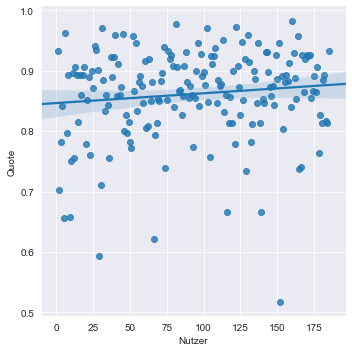

In [43]:
sns.lmplot(data=UebersichtNutzenSVD, x="Nutzer", y='Quote')

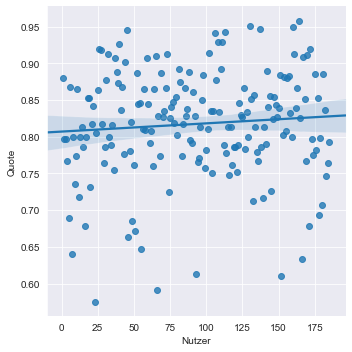

In [44]:
sns.lmplot(data=UebersichtProfitCutoffSVD, x="Nutzer", y='Quote')

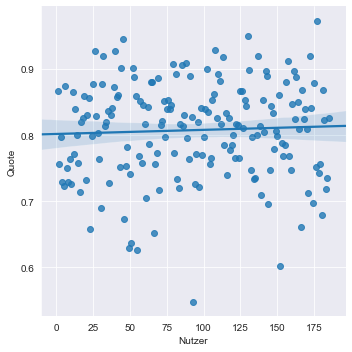

In [45]:
sns.lmplot(data=UebersichtProfitSVD, x="Nutzer", y='Quote')

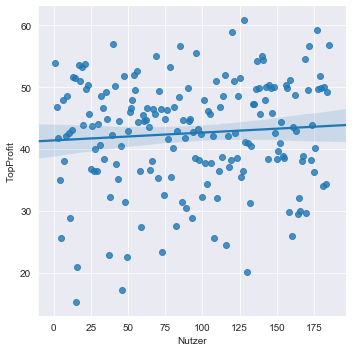

In [46]:
sns.lmplot(data=profit_df_svd, x="Nutzer", y='TopProfit')

In [47]:
import pylab as plt

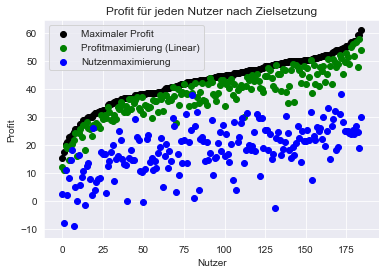

In [48]:
profit_sorted = profit_df_svd.sort_values(by=['TopProfit'], ascending=True)

Y1 = profit_df_svd['TopProfit'].sort_values(ascending=True)
Y1 = Y1.reset_index(drop=True)
Y2 = profit_sorted['Linear']
#Y3 = profit_sorted['Cutoff']
Y4 = profit_sorted['Est']
X = Y1.index
plt.scatter(X,Y1,color='k')
plt.scatter(X,Y2,color='g')
#plt.scatter(X,Y3,color='r')
plt.scatter(X,Y4,color='b')
plt.title("Profit für jeden Nutzer nach Zielsetzung")
plt.ylabel("Profit")
plt.xlabel("Nutzer")
plt.legend(('Maximaler Profit', 'Profitmaximierung (Linear)', 'Nutzenmaximierung'))
plt.show()

In [49]:
Y1

0      15.322421
1      17.184344
2      20.173694
3      21.009553
4      22.583048
         ...    
180    56.847898
181    56.947417
182    58.953262
183    59.278684
184    60.804783
Name: TopProfit, Length: 185, dtype: float64